# LightGBM 기본 코드

## #01. 준비작업

### [1] 패키지 가져오기

```shell
$ pip install lightgbm
```

In [70]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from helper.util import *
from helper.plot import *
from helper.analysis import *
from helper.classification import *
from helper.regression import *

from lightgbm import LGBMClassifier, LGBMRegressor, plot_importance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## #02. 분류분석

### [1] 데이터 가져오기 + 기본 데이터 처리

In [71]:
origin = my_read_excel(
    path="https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx",
    categories=["Outcome"],
    info=False,
)

# 정제 대상 필드명
zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# 0값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

# 훈련/검증 데이터 분할 및 데이터 표준화
x_train, x_test, y_train, y_test = my_train_test_split(df2, "Outcome", scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape


상위 5개 행
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |
|----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------|
|  0 |             6 |       148 |              72 |              35 |         0 |  33.6 |                      0.627 |    50 |         1 |
|  1 |             1 |        85 |              66 |              29 |         0 |  26.6 |                      0.351 |    31 |         0 |
|  2 |             8 |       183 |              64 |               0 |         0 |  23.3 |                      0.672 |    32 |         1 |
|  3 |             1 |        89 |              66 |              23 |        94 |  28.1 |                      0.167 |    21 |         0 |
|  4 |     

((614, 8), (154, 8), (614,), (154,))

### [2] LightGBM 모델 적합

> https://lightgbm.readthedocs.io/en/stable/Parameters.html

| 하이퍼파라미터          | 기능 설명                                                                 | 기본값 | 추천사항                                                      | 추천값                  |
|---------------------|----------------------------------------------------------------------|-------|-------------------------------------------------------------|----------------------|
| `num_leaves` | 하나의 트리가 가질 수 있는 최대 리프의 수                                       | 31    | 과적합을 방지하기 위해 적절한 수준으로 설정                                 | 20-40                 |
| `max_depth` | 트리의 최대 깊이, 과적합을 방지하기 위해 사용                                   | -1    | 큰 값으로 설정 시 더 깊은 트리 생성, -1은 제한 없음을 의미                           | 5-8                   |
| `learning_rate` | 학습률, 각 부스팅 스텝에서의 축소를 얼마나 강하게 할지 결정                         | 0.1   | 낮은 값으로 설정하여 점진적으로 학습, 더 많은 트리 필요                           | 0.01-0.1              |
| `num_iterations` 혹은 `n_estimators` | 부스팅 라운드의 수                                                        | 100   | 충분히 큰 값으로 설정하여 모델을 완전히 학습                                   | 100-1000              |
| `min_child_samples` | 결정 트리의 리프 노드가 되기 위해 필요한 최소 샘플 수                               | 20    | 과적합 방지를 위해 조절                                                | 10-30                 |
| `min_child_weight` | 자식에 필요한 모든 관측치의 가중치 합의 최소값, 과적합 조절에 사용                    | 0.001 | 과적합을 방지하기 위한 값 조정에 사용                                        | 0.001-0.1             |
| `subsample` | 각 트리를 구성할 때 사용되는 데이터 샘플의 비율, 과적합 방지                        | 1.0   | 0.8-1.0 사이로 설정하면 더 좋은 성능을 기대할 수 있음                              | 0.8-1.0               |
| `colsample_bytree` | 각 트리를 구성할 때 사용되는 피처의 비율, 과적합 방지                              | 1.0   | 0.6-0.9 사이로 설정하면 더 좋은 성능을 기대할 수 있음                              | 0.6-0.9               |
| `lambda_l1` | L1 정규화 가중치(라쏘) | 0 | | |
| `lambda_l2` | L2 정규화 가중치(릿지) | 0 | | |

In [72]:
estimator = LGBMClassifier(
    n_estimators=1000,
    num_leaves=64,
    n_jobs=get_n_jobs(),
    random_state=get_random_state(),
    early_stopping_rounds=5,
    verbose=-1
)

estimator.fit(x_train, y_train, eval_metric="error", eval_set=[(x_train, y_train), (x_test, y_test)])

LGBMClassifier(early_stopping_rounds=5, n_estimators=1000, n_jobs=-1,
               num_leaves=64, random_state=0, verbose=-1)

### [3] 분류 결과

#### (1) 예측값

In [73]:
estimator.predict(x_test)

array([1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0.])

#### (2) 예측확률

In [74]:
estimator.predict_proba(x_test)[:, 1]

array([0.66712948, 0.24218144, 0.24754732, 0.50216593, 0.18496196,
       0.19006058, 0.53179774, 0.64653807, 0.33920494, 0.3664168 ,
       0.61204526, 0.63272954, 0.18496196, 0.18312181, 0.29845401,
       0.49919287, 0.63534569, 0.17637116, 0.40636775, 0.23224153,
       0.54504451, 0.23709071, 0.18312181, 0.26739915, 0.17637116,
       0.47798844, 0.1814705 , 0.56146966, 0.19584598, 0.17579757,
       0.27892177, 0.32823962, 0.18782763, 0.34803643, 0.20703605,
       0.55536289, 0.31137999, 0.20703605, 0.27692845, 0.56231609,
       0.23894039, 0.21377436, 0.20515226, 0.56231609, 0.52898583,
       0.21049248, 0.20252418, 0.28919653, 0.36597184, 0.41210054,
       0.33463623, 0.1873749 , 0.62756726, 0.56695773, 0.21043812,
       0.20703605, 0.24914428, 0.26257966, 0.22154313, 0.51685946,
       0.60993054, 0.51286738, 0.1871409 , 0.57456104, 0.64074862,
       0.47558893, 0.50729145, 0.17579757, 0.43498945, 0.29845401,
       0.22069397, 0.17579757, 0.24325512, 0.65742308, 0.70078

### [4] 성능평가

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.822476 |     0.844156 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.873333 |     0.810811 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |      0.59276 |     0.638298 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0483461 |    0.0654206 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.951654 |     0.934579 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.706199 |     0.714286 | 정밀도와 재현율의 조화평균                                |
| AUC               |      0.92367 |     0.872142 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--

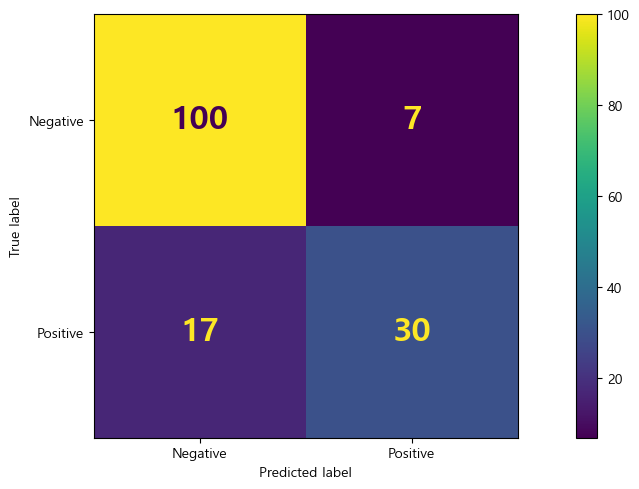


[Roc Curve]


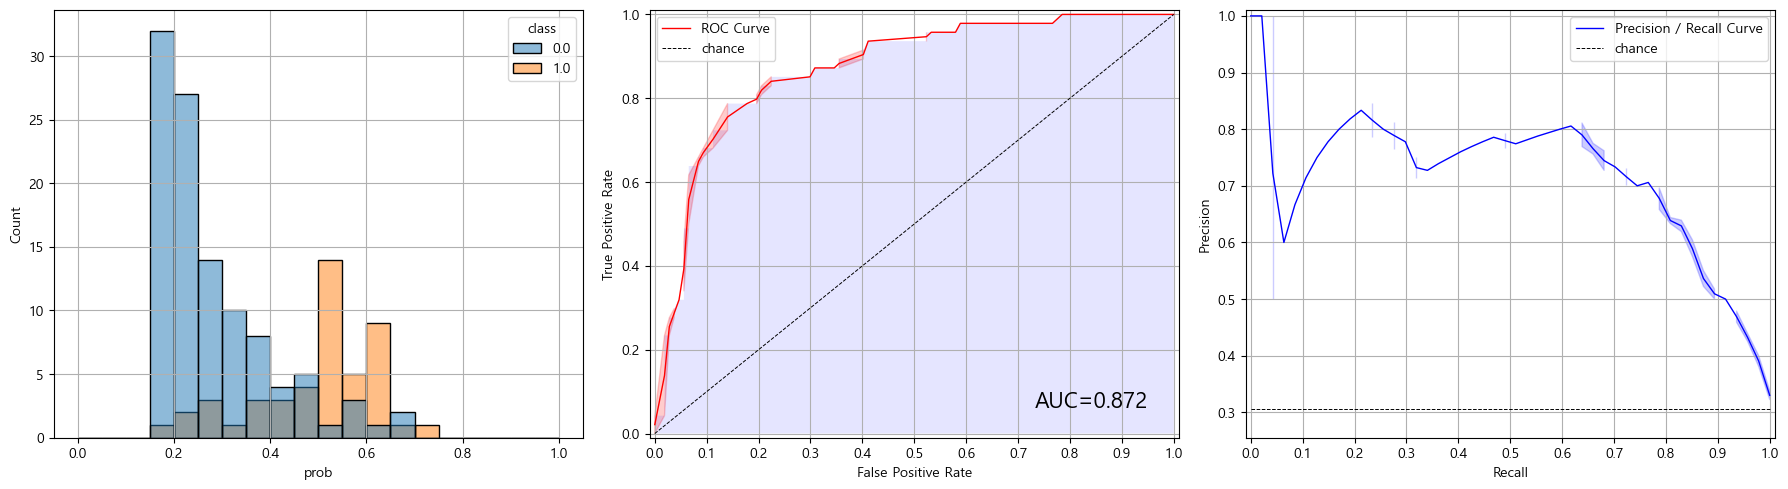


[학습곡선]
이 데이터는 학습곡선을 도출하는데 적합하지 않습니다.




In [75]:
my_classification_result(estimator, x_train, y_train, x_test, y_test)

### [5] 독립변수 보고

In [76]:
my_classification_report(estimator, x_train, y_train, x_test, y_test)

+----+------------+--------------------------+---------+
|    | 종속변수   | 독립변수                 |     VIF |
|----+------------+--------------------------+---------|
|  0 | Outcome    | Pregnancies              | 1.53706 |
|  1 | Outcome    | Glucose                  | 1.33393 |
|  2 | Outcome    | BloodPressure            | 1.25589 |
|  3 | Outcome    | SkinThickness            |  1.5504 |
|  4 | Outcome    | Insulin                  | 1.28711 |
|  5 | Outcome    | BMI                      | 1.52814 |
|  6 | Outcome    | DiabetesPedigreeFunction | 1.05376 |
|  7 | Outcome    | Age                      | 1.64872 |
+----+------------+--------------------------+---------+


### [6] 변수 중요도 확인

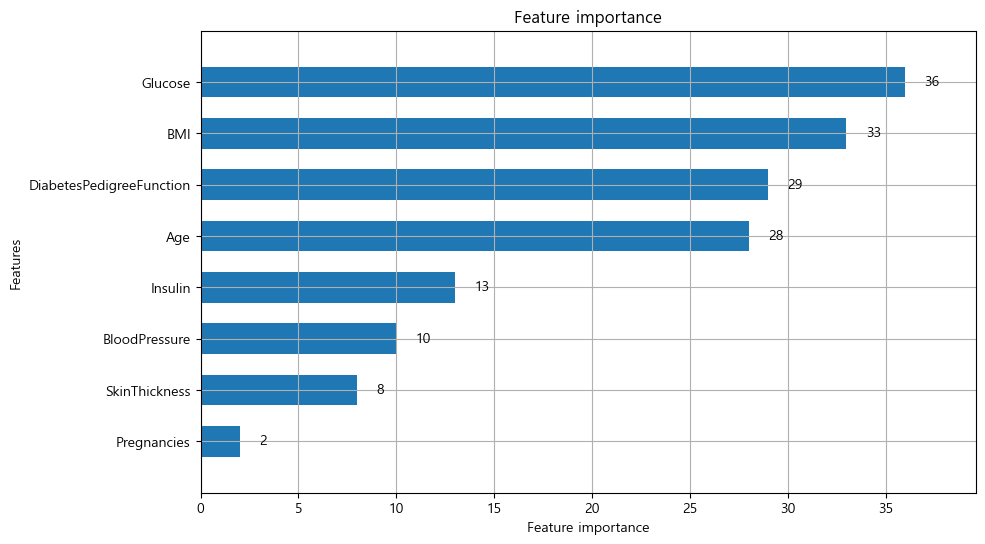

In [77]:
fig = plt.figure(figsize=(10, 6), dpi=100)
ax = fig.gca()
plot_importance(estimator, height=0.6, ax=ax)
plt.show()
plt.close()

In [78]:
#feature_important = estimator.get_booster().get_score(importance_type='weight')
#keys = list(feature_important.keys())
#values = list(feature_important.values())

keys = estimator.booster_.feature_name()
values = list(estimator.booster_.feature_importance())

data = DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

data['rate'] = data['score'] / data['score'].sum()
data['cumsum'] = data['rate'].cumsum()

data

,score,rate,cumsum
Glucose,36,0.226415,0.226415
BMI,33,0.207547,0.433962
DiabetesPedigreeFunction,29,0.182390,0.616352
Age,28,0.176101,0.792453
Insulin,13,0.081761,0.874214
BloodPressure,10,0.062893,0.937107
SkinThickness,8,0.050314,0.987421
Pregnancies,2,0.012579,1.000000


## #03. 회귀분석

### [1] 데이터 가져오기

In [79]:
origin = my_read_excel("https://data.hossam.kr/mldata/boston.xlsx", info=False)
x_train, x_test, y_train, y_test = my_train_test_split(origin, "MEDV", scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape


상위 5개 행
+----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------+
|    |    CRIM |   ZN |   INDUS |   CHAS |   NOX |    RM |   AGE |    DIS |   RAD |   TAX |   PTRATIO |      B |   LSTAT |   MEDV |
|----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------|
|  0 | 0.00632 |   18 |    2.31 |      0 | 0.538 | 6.575 |  65.2 |   4.09 |     1 |   296 |      15.3 |  396.9 |    4.98 |     24 |
|  1 | 0.02731 |    0 |    7.07 |      0 | 0.469 | 6.421 |  78.9 | 4.9671 |     2 |   242 |      17.8 |  396.9 |    9.14 |   21.6 |
|  2 | 0.02729 |    0 |    7.07 |      0 | 0.469 | 7.185 |  61.1 | 4.9671 |     2 |   242 |      17.8 | 392.83 |    4.03 |   34.7 |
|  3 | 0.03237 |    0 |    2.18 |      0 | 0.458 | 6.998 |  45.8 | 6.0622 |     3 |   222 |      18.7 | 394.63 |    2.94 |   33.4 |
|  4 | 0.06905 |    0 |    2.18 |      0 | 0.458 | 7.147 |  54.2 | 

((404, 13), (102, 13), (404,), (102,))

### [2] 학습 모델 적합

In [80]:
estimator = LGBMRegressor(
    n_estimators=1000,
    num_leaves=64,
    n_jobs=get_n_jobs(),
    random_state=get_random_state(),
    early_stopping_rounds=5,
    verbose=-1
)

estimator.fit(x_train, y_train, eval_metric="rmse", eval_set=[(x_train, y_train), (x_test, y_test)])

LGBMRegressor(early_stopping_rounds=5, n_estimators=1000, n_jobs=-1,
              num_leaves=64, random_state=0, verbose=-1)

### [3] 결과 예측

In [81]:
estimator.predict(x_test)

array([25.39411587, 23.35443823, 24.33462103, 11.1031673 , 20.94895933,
       20.37246612, 22.31803276, 20.04181099, 21.11769005, 18.46720305,
        9.21865525, 14.19552606, 14.4365282 ,  9.60784354, 46.83435876,
       36.03466875, 20.69998027, 39.86031326, 26.94723074, 21.41513954,
       23.63443206, 22.24747355, 19.54361578, 25.66140098, 20.94567705,
       17.77401221, 17.63350081, 15.52743567, 43.40522057, 19.6694648 ,
       16.57026585, 17.85419304, 19.00772309, 21.41460891, 26.17142931,
       18.40280039,  8.68743602, 22.31543217, 15.24507148, 14.94523153,
       22.70922832, 21.4742305 , 23.23297429, 16.18107842, 24.38757326,
       22.10730807, 20.56558837, 17.54043575, 15.65765567, 25.07610927,
       19.0157714 , 20.14389827, 21.99770448, 41.52807658, 15.11997682,
       20.49610971, 20.16324286, 19.39874385, 19.00813616, 19.65958679,
       22.60395374, 21.28789732, 30.91418766, 30.61585219, 19.03028682,
       29.81720856, 15.27878694, 20.88280365, 17.97964367, 22.33

### [4] 성능 평가

In [82]:
my_regression_result(estimator, x_train, y_train, x_test, y_test)

[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |     0.941937 |     0.692777 |
| 평균절대오차(MAE)             |      1.44754 |      2.93925 |
| 평균제곱오차(MSE)             |      4.94367 |      25.0167 |
| 평균오차(RMSE)                |      2.22344 |      5.00167 |
| 평균 절대 백분오차 비율(MAPE) |      7.24983 |      13.5943 |
| 평균 비율 오차(MPE)           |     -1.98743 |     -3.16601 |
+-------------------------------+--------------+--------------+

[학습곡선]
이 데이터는 학습곡선을 도출하는데 적합하지 않습니다.




### [4] 독립변수 보고

In [83]:
my_regression_report(estimator, x_train, y_train, x_test, y_test)

+----+------------+------------+---------+
|    | 종속변수   | 독립변수   |     VIF |
|----+------------+------------+---------|
|  0 | MEDV       | CRIM       | 2.09518 |
|  1 | MEDV       | ZN         | 2.33731 |
|  2 | MEDV       | INDUS      |  4.9238 |
|  3 | MEDV       | CHAS       | 1.32047 |
|  4 | MEDV       | NOX        | 4.17384 |
|  5 | MEDV       | RM         | 1.82706 |
|  6 | MEDV       | AGE        | 2.93317 |
|  7 | MEDV       | DIS        | 4.41185 |
|  8 | MEDV       | RAD        | 9.98804 |
|  9 | MEDV       | TAX        | 10.5503 |
| 10 | MEDV       | PTRATIO    | 1.88398 |
| 11 | MEDV       | B          |  1.5563 |
| 12 | MEDV       | LSTAT      |  2.8052 |
+----+------------+------------+---------+



### [6] 변수 중요도 확인

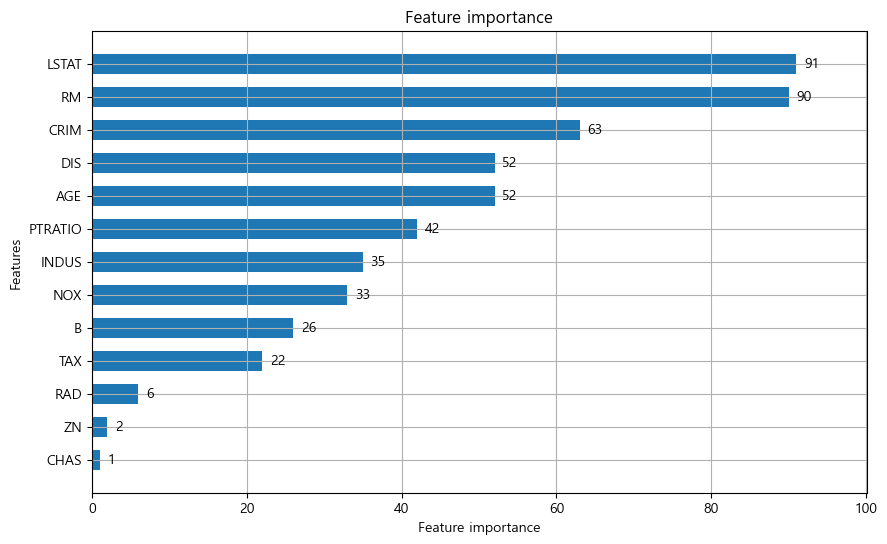

In [84]:
fig = plt.figure(figsize=(10, 6), dpi=100)
ax = fig.gca()
plot_importance(estimator, height=0.6, ax=ax)
plt.show()
plt.close()

In [85]:
keys = estimator.booster_.feature_name()
values = list(estimator.booster_.feature_importance())

data = DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

data['rate'] = data['score'] / data['score'].sum()
data['cumsum'] = data['rate'].cumsum()

data

,score,rate,cumsum
LSTAT,91,0.176699,0.176699
RM,90,0.174757,0.351456
CRIM,63,0.122330,0.473786
AGE,52,0.100971,0.574757
DIS,52,0.100971,0.675728
PTRATIO,42,0.081553,0.757282
INDUS,35,0.067961,0.825243
NOX,33,0.064078,0.889320
B,26,0.050485,0.939806
TAX,22,0.042718,0.982524
